In [1]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import io
import gzip
import itertools
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# %config InlineBackend.figure_formats = {'svg',}

# rc = {'lines.linewidth': 2, 
#       'axes.labelsize': 18, 
#       'axes.titlesize': 18, 
#       'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook')
sns.set_style('darkgrid')

# from code's nomenclature to paper nomenclature

column_map = {'p_1': r'$\sigma(\theta^*_1)$', 'p_2': r'$\sigma(\theta^*_2)$', 'Trial': 'Batch'}
estimator_map = {'ecb': 'DP', 'srswor': 'SRSWOR', 'rej': 'Reject', 'fs': 'SF', 'ais-cb-count' : 'AIS-C', 'ais-cb-gibbs': 'AIS-G'}

In [2]:
# read the csvs in the res/ directory
csvs = os.listdir('res')
buff = io.StringIO()
for n, c in enumerate(csvs):
    with gzip.open(f'res/{c}', 'rt') as f:
        if buff.tell():
            try:
                f.readline()
            except:
                continue
        buff.write(f.read())
buff.seek(0)
df = pd.read_csv(buff)

In [3]:
# check that most fields are constant
assert all(df['Total Number of Trials'] == 1024)
assert all(df['Training Batch Size'] == 64)
assert all(df['KL Batch Size'] == 256)
assert all(df['x Sequence Length'] == 32)
assert all(df['x Vector Length'] == 16)
assert all(df['x Standard Deviation'] == 1)
assert all(df['theta_3 Standard Deviation'] == 1)
assert all(df['Learning Rate'] == 1e-1)
assert all(df['LR Reduction Patience'] == 16)
assert all(df['LR Reduction Threshold'] == 1)
assert all(df['LR Reduction min'] == 1e-2)
# N.B. The reduction factor should've been 1e-1, but it's a harmless mistake b/c the LR min is 1e-2
assert all(df['LR Reduction Factor'] == 1e-2)
assert all(df['Optimizer'] == 'adam')
assert all(df['AIS Burn-in'] == 32)

df.head()

,Seed,Total Number of Trials,Training Batch Size,KL Batch Size,x Sequence Length,x Vector Length,p_1,p_2,x Standard Deviation,theta_3 Standard Deviation,Learning Rate,LR Reduction Patience,LR Reduction Threshold,LR Reduction Factor,LR Reduction min,Estimator,Optimizer,Number of Monte Carlo Samples,AIS Burn-in,Trial,SSE theta_1,SSE theta_2,SSE theta_3,Time Since Start,zhat Estimate,Log ESS,KL Batch Estimate
0,10,1024,64,256,32,16,0.25,0.75,1.0,1.0,0.1,16,1.0,0.01,0.01,ais-cb-gibbs,adam,256,32,1,4.160914,0.026264,447.979065,0 days 00:00:09.591841,-38.704182,3.174082,44.843487
1,10,1024,64,256,32,16,0.25,0.75,1.0,1.0,0.1,16,1.0,0.01,0.01,ais-cb-gibbs,adam,256,32,2,3.764713,0.004053,417.602051,0 days 00:00:18.501204,-38.635105,2.822479,44.872105
2,10,1024,64,256,32,16,0.25,0.75,1.0,1.0,0.1,16,1.0,0.01,0.01,ais-cb-gibbs,adam,256,32,3,3.392922,0.000987,388.885803,0 days 00:00:27.721951,-41.075539,2.587873,43.753750
3,10,1024,64,256,32,16,0.25,0.75,1.0,1.0,0.1,16,1.0,0.01,0.01,ais-cb-gibbs,adam,256,32,4,3.040538,0.015977,361.930145,0 days 00:00:36.741184,-29.348688,3.166414,36.620193
4,10,1024,64,256,32,16,0.25,0.75,1.0,1.0,0.1,16,1.0,0.01,0.01,ais-cb-gibbs,adam,256,32,5,2.711953,0.047092,337.564117,0 days 00:00:45.525250,-35.630577,2.612307,33.432770


In [4]:
# KL Batch Estimate Stats
df[df['Trial'] == 1024].groupby(['p_2', 'p_1', 'Number of Monte Carlo Samples', 'Estimator'])['KL Batch Estimate'].describe()

count        mean  \
p_2  p_1  Number of Monte Carlo Samples Estimator                         
0.00 0.25 1                             ecb            20.0    0.046768   
                                        fs             20.0   13.209222   
                                        rej            20.0   24.071596   
                                        srswor         20.0   12.838377   
          128                           ais-cb-count   20.0    4.321863   
                                        ais-cb-gibbs   20.0    1.162940   
                                        fs             20.0    5.731982   
                                        rej            20.0   19.865246   
                                        srswor         20.0    4.630269   
          256                           ais-cb-count   20.0    3.156462   
                                        fs             20.0    4.973411   
                                        rej            20.0   19.183667   
                                        srswor         20.0    3.967984   
          512                           ais-cb-count   20.0    1.876342   
                                        fs             20.0    4.289172   
                                        rej            20.0   15.310291   
                                        srswor         20.0    3.367444   
          1024                          ais-cb-count   20.0    0.845899   
                                        fs             20.0    3.709692   
                                        rej            20.0   14.851152   
                                        srswor         20.0    2.842647   
     0.75 1                             ecb            20.0    0.062282   
                                        fs             20.0   30.561901   
                                        rej            20.0   49.780629   
                                        srswor         20.0   28.131890   
          128                           ais-cb-count   20.0    5.953508   
                                        ais-cb-gibbs   20.0    1.728876   
                                        fs             20.0    9.694171   
                                        rej            20.0  162.537512   
                                        srswor         20.0    8.050409   
          256                           ais-cb-count   20.0    3.421957   
                                        ais-cb-gibbs   20.0    0.293224   
                                        fs             20.0    8.148930   
                                        rej            20.0  161.647772   
                                        srswor         20.0    6.717293   
          512                           ais-cb-count   20.0    1.697010   
                                        fs             20.0    6.862077   
                                        rej            20.0  162.545213   
                                        srswor         20.0    5.565863   
          1024                          ais-cb-count   20.0    0.833785   
                                        fs             20.0    5.630839   
                                        rej            20.0  162.584607   
                                        srswor         20.0    4.514088   
0.25 0.25 1                             ecb            20.0    0.229257   
                                        fs             20.0   13.393871   
                                        rej            20.0   13.345946   
                                        srswor         20.0   12.808408   
          128                           ais-cb-count   20.0    4.394367   
                                        ais-cb-gibbs   20.0    1.443222   
                                        fs             20.0    6.109353   
                                        rej            20.0    8.032510   
                                        srswor         20.0    4.715281   
    

In [5]:
# SSE theta_1 stats
df[df['Trial'] == 1024].groupby(['p_2', 'p_1', 'Number of Monte Carlo Samples', 'Estimator'])['SSE theta_1'].describe()

count      mean  \
p_2  p_1  Number of Monte Carlo Samples Estimator                       
0.00 0.25 1                             ecb            20.0  0.000271   
                                        fs             20.0  0.000271   
                                        rej            20.0  1.065329   
                                        srswor         20.0  0.000271   
          128                           ais-cb-count   20.0  0.000271   
                                        ais-cb-gibbs   20.0  0.000271   
                                        fs             20.0  0.000271   
                                        rej            20.0  1.119859   
                                        srswor         20.0  0.000271   
          256                           ais-cb-count   20.0  0.000271   
                                        fs             20.0  0.000271   
                                        rej            20.0  1.119826   
                                        srswor         20.0  0.000271   
          512                           ais-cb-count   20.0  0.000271   
                                        fs             20.0  0.000271   
                                        rej            20.0  0.847289   
                                        srswor         20.0  0.000271   
          1024                          ais-cb-count   20.0  0.000271   
                                        fs             20.0  0.000271   
                                        rej            20.0  0.890844   
                                        srswor         20.0  0.000271   
     0.75 1                             ecb            20.0  0.000170   
                                        fs             20.0  0.000170   
                                        rej            20.0  0.839983   
                                        srswor         20.0  0.000170   
          128                           ais-cb-count   20.0  0.000170   
                                        ais-cb-gibbs   20.0  0.000170   
                                        fs             20.0  0.000170   
                                        rej            20.0  2.272923   
                                        srswor         20.0  0.000170   
          256                           ais-cb-count   20.0  0.000170   
                                        ais-cb-gibbs   20.0  0.000170   
                                        fs             20.0  0.000170   
                                        rej            20.0  2.258920   
                                        srswor         20.0  0.000170   
          512                           ais-cb-count   20.0  0.000170   
                                        fs             20.0  0.000170   
                                        rej            20.0  2.253645   
                                        srswor         20.0  0.000170   
          1024                          ais-cb-count   20.0  0.000170   
                                        fs             20.0  0.000170   
                                        rej            20.0  2.294067   
                                        srswor         20.0  0.000170   
0.25 0.25 1                             ecb            20.0  0.000291   
                                        fs             20.0  0.000848   
                                        rej            20.0  0.017239   
                                        srswor         20.0  0.000341   
          128                           ais-cb-count   20.0  0.000310   
                                        ais-cb-gibbs   20.0  0.000342   
                                        fs             20.0  0.000320   
                                        rej            20.0  0.003129   
                                        srswor         20.0  0.000338   
          256                           ais-cb-count   20.0  0.000298   
                                       

In [6]:
# SSE theta_2 stats (skipped p_2 == 0, since it is untrained, and Estimator == ecb, because it's fixed at p_2 == 0)
df[(df['Trial'] == 1024) & (df['p_2'] != 0) & (df['Estimator'] != "ecb")].groupby(['p_2', 'p_1', 'Number of Monte Carlo Samples', 'Estimator'])['SSE theta_2'].describe()

count      mean  \
p_2  p_1  Number of Monte Carlo Samples Estimator                       
0.25 0.25 1                             fs             20.0  0.024127   
                                        rej            20.0  6.329940   
                                        srswor         20.0  0.209503   
          128                           ais-cb-count   20.0  0.019306   
                                        ais-cb-gibbs   20.0  0.042459   
                                        fs             20.0  0.003060   
                                        rej            20.0  0.413235   
                                        srswor         20.0  0.016373   
          256                           ais-cb-count   20.0  0.015802   
                                        ais-cb-gibbs   20.0  0.027055   
                                        fs             20.0  0.001853   
                                        rej            20.0  0.269426   
                                        srswor         20.0  0.012668   
          512                           ais-cb-count   20.0  0.015132   
                                        fs             20.0  0.001472   
                                        rej            20.0  0.184510   
                                        srswor         20.0  0.009453   
          1024                          ais-cb-count   20.0  0.016139   
                                        fs             20.0  0.001102   
                                        rej            20.0  0.140052   
                                        srswor         20.0  0.007166   
     0.75 1                             fs             20.0  0.026610   
                                        rej            20.0  4.480332   
                                        srswor         20.0  0.198061   
          128                           ais-cb-count   20.0  0.009959   
                                        ais-cb-gibbs   20.0  0.021660   
                                        fs             20.0  0.001811   
                                        rej            20.0  2.085535   
                                        srswor         20.0  0.016324   
          256                           ais-cb-count   20.0  0.007092   
                                        ais-cb-gibbs   20.0  0.011052   
                                        fs             20.0  0.001940   
                                        rej            20.0  2.119812   
                                        srswor         20.0  0.012856   
          512                           ais-cb-count   20.0  0.005343   
                                        fs             20.0  0.001637   
                                        rej            20.0  1.925591   
                                        srswor         20.0  0.010188   
          1024                          ais-cb-count   20.0  0.004523   
                                        fs             20.0  0.001803   
                                        rej            20.0  1.773279   
                                        srswor         20.0  0.008212   
0.75 0.25 1                             fs             20.0  0.030203   
                                        rej            20.0  3.476708   
                                        srswor         20.0  0.001252   
          128                           ais-cb-count   20.0  0.000700   
                                        ais-cb-gibbs   20.0  0.000612   
                                        fs             20.0  0.001191   
                                        rej            20.0  1.387573   
                                        srswor         20.0  0.000662   
          256                           ais-cb-count   20.0  0.000722   
                                        ais-cb-gibbs   20.0  0.000609   
                                        fs             20.0  0.001047   
                                       

In [7]:
# SSE theta_3 stats
df[df['Trial'] == 1024].groupby(['p_2', 'p_1', 'Number of Monte Carlo Samples', 'Estimator'])['SSE theta_3'].describe()

count        mean  \
p_2  p_1  Number of Monte Carlo Samples Estimator                         
0.00 0.25 1                             ecb            20.0   35.922936   
                                        fs             20.0  264.062398   
                                        rej            20.0  298.230982   
                                        srswor         20.0  260.196059   
          128                           ais-cb-count   20.0  154.013860   
                                        ais-cb-gibbs   20.0   80.467844   
                                        fs             20.0  178.977282   
                                        rej            20.0  258.763154   
                                        srswor         20.0  159.786199   
          256                           ais-cb-count   20.0  130.915617   
                                        fs             20.0  165.629321   
                                        rej            20.0  247.501646   
                                        srswor         20.0  148.831992   
          512                           ais-cb-count   20.0  101.286267   
                                        fs             20.0  155.251609   
                                        rej            20.0  222.606131   
                                        srswor         20.0  136.606550   
          1024                          ais-cb-count   20.0   69.982391   
                                        fs             20.0  143.709047   
                                        rej            20.0  211.559632   
                                        srswor         20.0  125.594898   
     0.75 1                             ecb            20.0   52.759699   
                                        fs             20.0  238.315021   
                                        rej            20.0  261.756635   
                                        srswor         20.0  229.307942   
          128                           ais-cb-count   20.0  115.602773   
                                        ais-cb-gibbs   20.0   73.202908   
                                        fs             20.0  142.724252   
                                        rej            20.0  506.315689   
                                        srswor         20.0  130.856094   
          256                           ais-cb-count   20.0   91.880593   
                                        ais-cb-gibbs   20.0   53.729399   
                                        fs             20.0  132.146246   
                                        rej            20.0  504.435533   
                                        srswor         20.0  120.997045   
          512                           ais-cb-count   20.0   73.105410   
                                        fs             20.0  122.463193   
                                        rej            20.0  505.369218   
                                        srswor         20.0  111.225666   
          1024                          ais-cb-count   20.0   62.046086   
                                        fs             20.0  112.633692   
                                        rej            20.0  505.593414   
                                        srswor         20.0  102.528727   
0.25 0.25 1                             ecb            20.0   36.691051   
                                        fs             20.0  265.723550   
                                        rej            20.0  255.588194   
                                        srswor         20.0  260.810201   
          128                           ais-cb-count   20.0  155.175806   
                                        ais-cb-gibbs   20.0   88.698508   
                                        fs             20.0  184.429545   
                                        rej            20.0  205.736366   
                                        srswor         20.0  161.834349   
    

In [8]:
# runtime stats
df['Time Since Start'] = pd.to_timedelta(df['Time Since Start'])
df[df['Trial'] == 1024].groupby(['Number of Monte Carlo Samples', 'Estimator'])['Time Since Start'].describe()

count                    mean  \
Number of Monte Carlo Samples Estimator                                    
1                             ecb            120  0 days 00:00:27.752772   
                              fs             120  0 days 00:00:22.877358   
                              rej            120  0 days 00:00:12.510533   
                              srswor         120  0 days 00:00:20.450694   
128                           ais-cb-count   120  0 days 00:17:19.082334   
                              ais-cb-gibbs   120  0 days 01:10:28.023423   
                              fs             120  0 days 00:01:17.516576   
                              rej            120  0 days 00:00:52.945499   
                              srswor         120  0 days 00:01:10.925139   
256                           ais-cb-count   120  0 days 00:35:43.657982   
                              ais-cb-gibbs   100  0 days 02:09:55.092272   
                              fs             120  0 days 00:02:39.145221   
                              rej            120  0 days 00:02:03.694473   
                              srswor         120  0 days 00:02:17.001339   
512                           ais-cb-count   120  0 days 01:15:04.495256   
                              fs             120  0 days 00:08:37.233981   
                              rej            120  0 days 00:04:14.609481   
                              srswor         120  0 days 00:05:08.064336   
1024                          ais-cb-count    80  0 days 02:20:21.990454   
                              fs             120  0 days 00:12:05.070278   
                              rej            120  0 days 00:07:31.182964   
                              srswor         120  0 days 00:10:13.463305   

                                                               std  \
Number of Monte Carlo Samples Estimator                              
1                             ecb           0 days 00:00:05.603179   
                              fs            0 days 00:00:26.325871   
                              rej           0 days 00:00:00.922102   
                              srswor        0 days 00:00:33.729527   
128                           ais-cb-count  0 days 00:03:31.256627   
                              ais-cb-gibbs  0 days 00:15:27.469455   
                              fs            0 days 00:00:12.896126   
                              rej           0 days 00:00:11.176304   
                              srswor        0 days 00:00:10.344165   
256                           ais-cb-count  0 days 00:05:10.400149   
                              ais-cb-gibbs  0 days 00:28:42.956002   
                              fs            0 days 00:00:17.963877   
                              rej           0 days 00:00:29.662238   
                              srswor        0 days 00:00:16.798550   
512                           ais-cb-count  0 days 00:11:06.047291   
                              fs            0 days 00:07:36.413777   
                              rej           0 days 00:01:04.640037   
                              srswor        0 days 00:00:52.202272   
1024                          ais-cb-count  0 days 00:14:09.002595   
                              fs            0 days 00:02:05.868053   
                              rej           0 days 00:01:21.754251   
                              srswor        0 days 00:01:15.474920   

                                                               min  \
Number of Monte Carlo Samples Estimator                              
1                             ecb           0 days 00:00:22.092278   
                              fs            0 days 00:00:11.783868   
                              rej           0 days 00:00:10.165995   
                              srswor        0 days 00:00:12.036111   
128                           ais-cb-count  0 days 00:11:23.070177   
                              ais-cb-gibbs  0 d

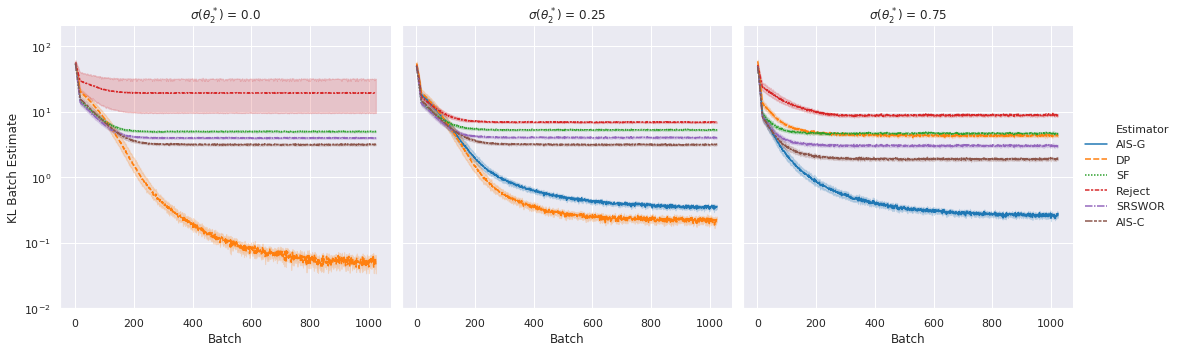

In [9]:
# visualize convergence for paper
# note we map values to match paper conventions
df_ = (
    df[((df['Number of Monte Carlo Samples'] == 256) | (df['Estimator'] == 'ecb')) & (df['p_1'] == 0.25)]
    .rename(columns=column_map)
)
df_['Estimator'] = df_['Estimator'].apply(estimator_map.get)
g = sns.relplot(
    x="Batch",
    y="KL Batch Estimate",
    hue="Estimator", style="Estimator",
    col=r'$\sigma(\theta^*_2)$',
    kind="line",
    data=df_,
)
g.set(yscale='log', ylim=[1e-2, 200])
g.savefig('convergence.pdf')
g

In [10]:
# print table for our paper supplementary material (requires booktabs + multirow + multicolumn)
f = open('full_table.tex', 'w')

df_ = df[(df['Trial'] == 1024)].copy()
df_['Number of Monte Carlo Samples'] = df_['Number of Monte Carlo Samples'].where(df_['Estimator'] != "ecb", 0)
kl_stats = df_.groupby(['Number of Monte Carlo Samples', 'Estimator', 'p_1', 'p_2'])['KL Batch Estimate'].describe()

# fill missing values with NaN
mi = pd.MultiIndex.from_product(kl_stats.index.levels)
mi = mi[(mi.get_level_values(1) == "ecb") == (mi.get_level_values(0) == 0)]
mi = mi[((mi.get_level_values(1) != 'ais-cb-gibbs') & (mi.get_level_values(1) != 'ais-cb-count')) | (mi.get_level_values(0) != 1)]
kl_stats_ = kl_stats.reindex(mi)

mean_fmt = r'${:.2f}({:.2f})$'
entry_fmt = '& '.join([r'{:<21}', r'{:<7}', ' '] + [r'{:<15}'] * 6)

print(r'''
\begin{tabular}{lllccc|ccc}
\toprule
\multirow{3}{*}{$n_*$} & \multirow{3}{*}{ESTIMATOR} && \multicolumn{6}{c}{KL EST. MEAN (STD)} \\
\cmidrule{4-9}
&&$\sigma(\theta^*_1)$& \multicolumn{3}{c|}{$0.25$} & \multicolumn{3}{c}{$0.75$} \\
&&$\sigma(\theta^*_2)$& $0.00$ & $0.25$ & $0.75$ & $0.00$ & $0.25$ & $0.75$ ''', file=f)

for nmax in sorted(set(mi.get_level_values(0))):
    print(r'\\', file=f)
    print(r'\midrule', file=f)
    kl_stats_nmax = kl_stats_.loc[nmax]
    assert len(kl_stats_nmax) % 6 == 0
    num_nmax_entries = len(kl_stats_nmax) // 6
    nmax_entry = f'\\multirow{{{num_nmax_entries}}}{{*}}{{{nmax if nmax else "--"}}}'
    for ne, estimator in enumerate(sorted(set(kl_stats_nmax.index.get_level_values(0)))):
        if ne:
            print(r'\\', file=f)
        kl_stats_estimator = kl_stats_nmax.loc[estimator]
        assert len(kl_stats_estimator) == 6
        mean_stds = ('--' if np.isnan(x.mean) else mean_fmt.format(x.mean, x.std) for x in kl_stats_estimator.itertuples())
        print(entry_fmt.format(nmax_entry, estimator_map[estimator], *mean_stds), end='', file=f)
        nmax_entry = ''
print('\\\\\n\\bottomrule', file=f)
print(r'\end{tabular}', file=f)

f.close()

In [11]:
# print reduced table for paper
f = open('reduced_table.tex', 'w')

df_ = df[(df['Trial'] == 1024) & (df['p_1'] == 0.25)].copy()
df_['Number of Monte Carlo Samples'] = df_['Number of Monte Carlo Samples'].where(df_['Estimator'] != "ecb", 0)
kl_stats = df_.groupby(['p_2', 'Number of Monte Carlo Samples', 'Estimator'])['KL Batch Estimate'].describe()

levels = [list(x) for x in kl_stats.index.levels]
# remove nmax in {1, 512, 1024}
levels[1].remove(1)
levels[1].remove(512)
levels[1].remove(1024)
mi = pd.MultiIndex.from_product(levels)
mi = mi[(mi.get_level_values(2) == "ecb") == (mi.get_level_values(1) == 0)]
kl_stats_ = kl_stats.reindex(mi)

mean_fmt = r'${:.2f}({:.2f})$'
entry_fmt = '  {:<23}& {:<21}& {:<10}& {:<24}\\\\'
print(r'''\begin{tabular}{lllc}
  \toprule''', file=f)
print(entry_fmt.format(r'$\sigma(\theta^*_2)$', '$n_*$', 'ESTIMATOR', 'MEAN (STD)'), file=f)

for p_2 in sorted(set(mi.get_level_values(0))):
    print(r'  \midrule', file=f)
    kl_stats_p_2 = kl_stats_.loc[p_2]
    num_p_2_entries = len(kl_stats_p_2)
    p_2_entry = f'\\multirow{{{num_p_2_entries}}}{{*}}{{{p_2:.2f}}}'
    for nn, nmax in enumerate(sorted(set(kl_stats_p_2.index.get_level_values(0)))):
        if nn:
            print(r'  \cmidrule{2-4}', file=f)
        kl_stats_nmax = kl_stats_p_2.loc[nmax]
        num_nmax_entries = len(kl_stats_nmax)
        nmax_entry = f'\\multirow{{{num_nmax_entries}}}{{*}}{{{nmax if nmax else "--"}}}'
        max_ = max(kl_stats_nmax['mean'])
        for ne, entry in enumerate(kl_stats_nmax.itertuples()):
            mean_std = '--' if np.isnan(entry.mean) else mean_fmt.format(entry.mean, entry.std)
#             if entry.mean == max_:
#                 mean_std = r'\textbf{' + mean_std + r'}'
            print(entry_fmt.format(p_2_entry,nmax_entry, estimator_map[entry.Index], mean_std), file=f)
            p_2_entry = nmax_entry = ''
print(r'  \bottomrule', file=f)
print(r'\end{tabular}', file=f)

f.close()